In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai import *
import os
from collections import defaultdict

### Set up paths

In [2]:
train_pd = pd.read_csv('/root/.fastai/data/severstal/train.csv')

In [3]:
train_pd.head(5)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [5]:
path = Path('/root/.fastai/data/severstal')

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/severstal/severstal-steel-defect-detection.zip'),
 PosixPath('/root/.fastai/data/severstal/test_images'),
 PosixPath('/root/.fastai/data/severstal/train_images'),
 PosixPath('/root/.fastai/data/severstal/train.csv'),
 PosixPath('/root/.fastai/data/severstal/submission.csv'),
 PosixPath('/root/.fastai/data/severstal/train_images.zip'),
 PosixPath('/root/.fastai/data/severstal/sample_submission.csv'),
 PosixPath('/root/.fastai/data/severstal/test_images.zip')]

In [7]:
train_images = get_image_files(path/'train_images')
train_images[:3]

[PosixPath('/root/.fastai/data/severstal/train_images/18ba753ff.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/0519989b3.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/7933cbe21.jpg')]

### Check maximum size of images

In [8]:
def check_img_max_size(folder):
    max_height = 0
    max_width = 0
    for train_image in train_images:
        img = open_image(train_image)
        if max_height < img.shape[1]:
            max_height = img.shape[1]
        if max_width < img.shape[2]:
            max_width = img.shape[2]
    return max_height, max_width

def show_image(images, index):
    img_f = images[index]
    print(type(img_f))
    img = open_image(img_f)
    print(img)
    img.show(figsize=(5,5))

<class 'pathlib.PosixPath'>
Image (3, 256, 1600)


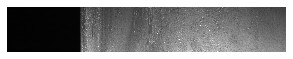

In [9]:
show_image(train_images, 0)

In [10]:
mask_path = Path('/kaggle/mask')
if not os.path.exists(mask_path):
    os.makedirs(str(mask_path))

In [11]:
def convert_encoded_to_array(encoded_pixels):
    pos_array = []
    len_array = []
    splits = encoded_pixels.split()
    pos_array = [int(n) - 1 for i, n in enumerate(splits) if i % 2 == 0]
    len_array = [int(n) for i, n in enumerate(splits) if i % 2 == 1]
    return pos_array, len_array
        
def convert_to_pair(pos_array, rows):
    return [(p % rows, p // rows) for p in pos_array]

def create_positions(single_pos, size):
    return [i for i in range(single_pos, single_pos + size)]

def create_positions_pairs(single_pos, size, row_size):
    return convert_to_pair(create_positions(single_pos, size), row_size)

def convert_to_mask(encoded_pixels, row_size, col_size, category):
    pos_array, len_array = convert_encoded_to_array(encoded_pixels)
    mask = np.zeros([row_size, col_size])
    for(p, l) in zip(pos_array, len_array):
        for row, col in create_positions_pairs(p, l, row_size):
            mask[row][col] = category
    return mask

def save_to_image(masked, image_name):
    im = PIL.Image.fromarray(masked)
    im = im.convert("L")
    image_name = re.sub(r'(.+)\.jpg', r'\1', image_name) + ".png"
    real_path = mask_path/image_name
    im.save(real_path)
#     print(f'Image saved to ${real_path}')
    return real_path

def open_single_image(path):
    img = open_image(path)
    img.show(figsize=(20,20))
    
def get_y_fn(x):
    return mask_path/(x.stem + '.png')

def group_by(train_images, train_pd):
    tran_dict = {image.name:[] for image in train_images}
    pattern = re.compile('(.+)_(\d+)')
    for index, image_path in train_pd.iterrows():
        m = pattern.match(image_path['ImageId_ClassId'])
        file_name = m.group(1)
        category = m.group(2)
        tran_dict[file_name].append((int(category), image_path['EncodedPixels']))
    return tran_dict

def display_image_with_mask(img_name):
    full_image = path/'train_images'/img_name
    print(full_image)
    open_single_image(full_image)
    mask_image = get_y_fn(full_image)
    mask = open_mask(mask_image)
    print(full_image)
    mask.show(figsize=(20, 20), alpha=0.5)

In [12]:
grouped_categories_mask = group_by(train_images, train_pd)

### Fetching images with more than n categories

In [13]:
def add_mask(cat_mask):
    sum = 0
    if pd.notna(cat_mask[0][1]):
        sum += 1
    if pd.notna(cat_mask[1][1]):
        sum += 1
    if pd.notna(cat_mask[2][1]):
        sum += 1
    if pd.notna(cat_mask[3][1]):
        sum += 1
    return sum

multi_cat = [i[0] for i in grouped_categories_mask.items() if add_mask(i[1]) > 2]
multi_cat

['db4867ee8.jpg', 'ef24da2ba.jpg']

### Create mask files and save these to kaggle/mask/

In [14]:
image_height = 256
image_width = 1600
for image_name, cat_list in grouped_categories_mask.items():
    masked = np.zeros([image_height, image_width])
    for cat_mask in cat_list:
        encoded_pixels = cat_mask[1]
        if pd.notna(cat_mask[1]):
            masked += convert_to_mask(encoded_pixels, image_height, image_width, cat_mask[0])
    if np.amax(masked) > 4:
        print(f'Check {image_name} for max category {np.amax(masked)}')
    save_to_image(masked, image_name)

In [ ]:
# check_img_max_size(mask_path)

[(0, 0), (1, 0), (2, 0), (0, 1), (1, 1), (2, 1)]
[(173, 113), (161, 114), (161, 115), (161, 116), (161, 117), (161, 118), (161, 119), (161, 120), (162, 121), (162, 122), (162, 123), (162, 124), (162, 125), (162, 126), (162, 127), (93, 304), (93, 305), (92, 306), (92, 307), (92, 308), (92, 309), (91, 310), (91, 311), (91, 312), (91, 313), (90, 314), (90, 315), (90, 316), (89, 317), (89, 318), (89, 319), (89, 320), (88, 321), (88, 322), (123, 322), (90, 323), (129, 323), (93, 324), (135, 324), (96, 325), (141, 325), (98, 326), (147, 326), (101, 327), (153, 327), (104, 328), (159, 328), (165, 329), (171, 330), (181, 331), (246, 332), (227, 333), (209, 334), (199, 335), (199, 336), (198, 337), (198, 338), (198, 339), (197, 340), (197, 341), (197, 342), (196, 343), (196, 344), (196, 345), (195, 346), (195, 347), (194, 348), (194, 349), (66, 350), (194, 350), (66, 351), (193, 351), (66, 352), (193, 352), (65, 353), (193, 353), (65, 354), (192, 354), (65, 355), (192, 355), (65, 356), (65, 357

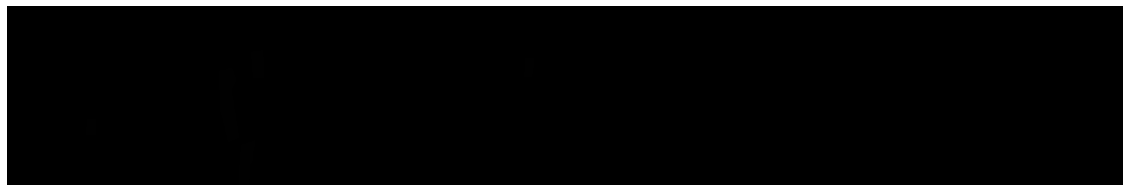

In [15]:
pos_array, len_array = convert_encoded_to_array(train_pd[0:1]['EncodedPixels'][0])
print(convert_to_pair([0, 1, 2, 3, 4, 5], 3))
print(convert_to_pair(pos_array, 256))
print(create_positions(3, 4))
create_positions_pairs(3, 4, 3)
# masked = convert_to_mask(pd.Series(["1 3 10 5"]), 3, 6, 1)
# masked
masked = convert_to_mask(train_pd[:1]['EncodedPixels'][0], 256, 1600, 1)
df_masked = pd.DataFrame (masked)
im = PIL.Image.fromarray(masked)
im = im.convert("L")
dummy_img = re.sub(r'(.+)_\d+', r'\1', train_pd[0:1]['ImageId_ClassId'][0])
real_path = save_to_image(masked, dummy_img)
open_single_image(real_path)

#### Data checks

/root/.fastai/data/severstal/train_images/d482f0159.jpg
/root/.fastai/data/severstal/train_images/d482f0159.jpg


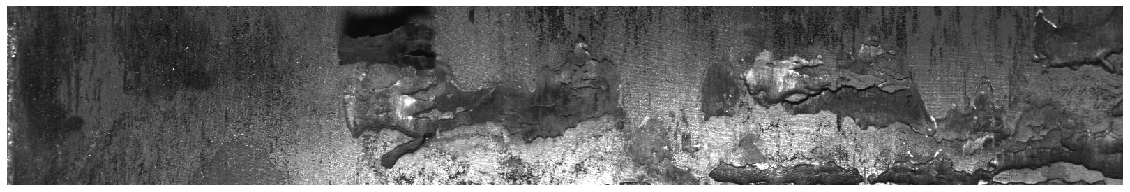

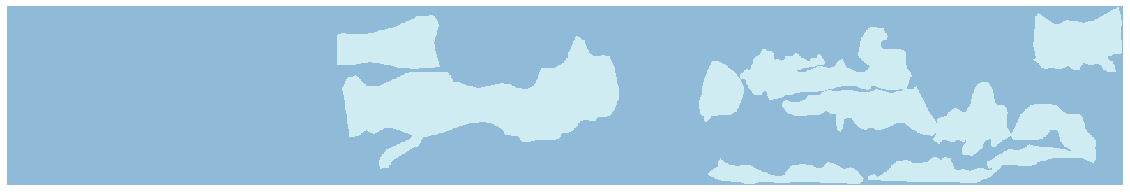

In [16]:
display_image_with_mask('d482f0159.jpg')

/root/.fastai/data/severstal/train_images/db4867ee8.jpg
/root/.fastai/data/severstal/train_images/db4867ee8.jpg


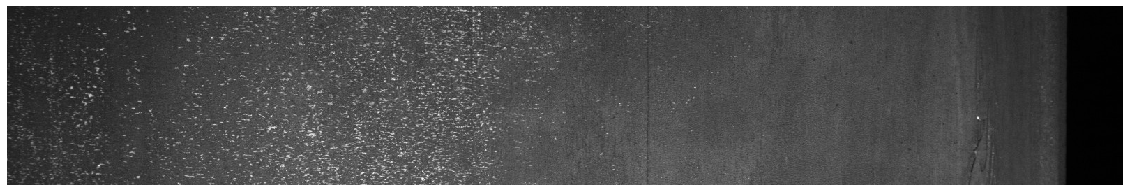

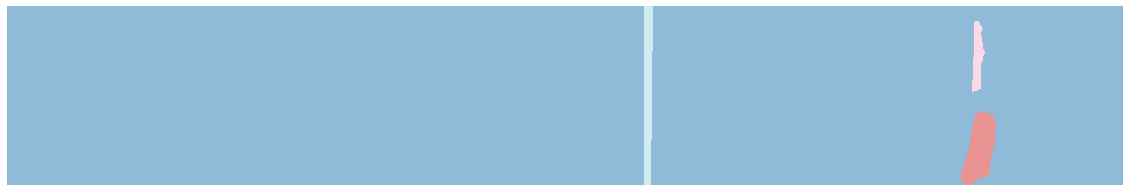

In [17]:
display_image_with_mask('db4867ee8.jpg')

In [18]:
mask = open_mask(get_y_fn(Path('/root/.fastai/data/severstal/ee21b4b2d.jpg')))

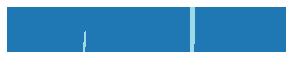

In [19]:
mask.show(figsize=(5,5), alpha=1)

In [ ]:
from IPython.display import HTML
import base64

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


im = PIL.Image.open("/kaggle/mask/db4867ee8.png")
create_download_link(pd.DataFrame(np.array(im)))

### Prepare data bunch

In [20]:
train_images = (path/'train_images').ls()
src_size = np.array(open_image(str(train_images[0])).shape[1:])

In [21]:
codes = array(['0', '1', '2', '3', '4'])
src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [118]:
bs, size = 2, src_size//4

In [23]:
data = (src.transform(get_transforms(flip_vert = True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

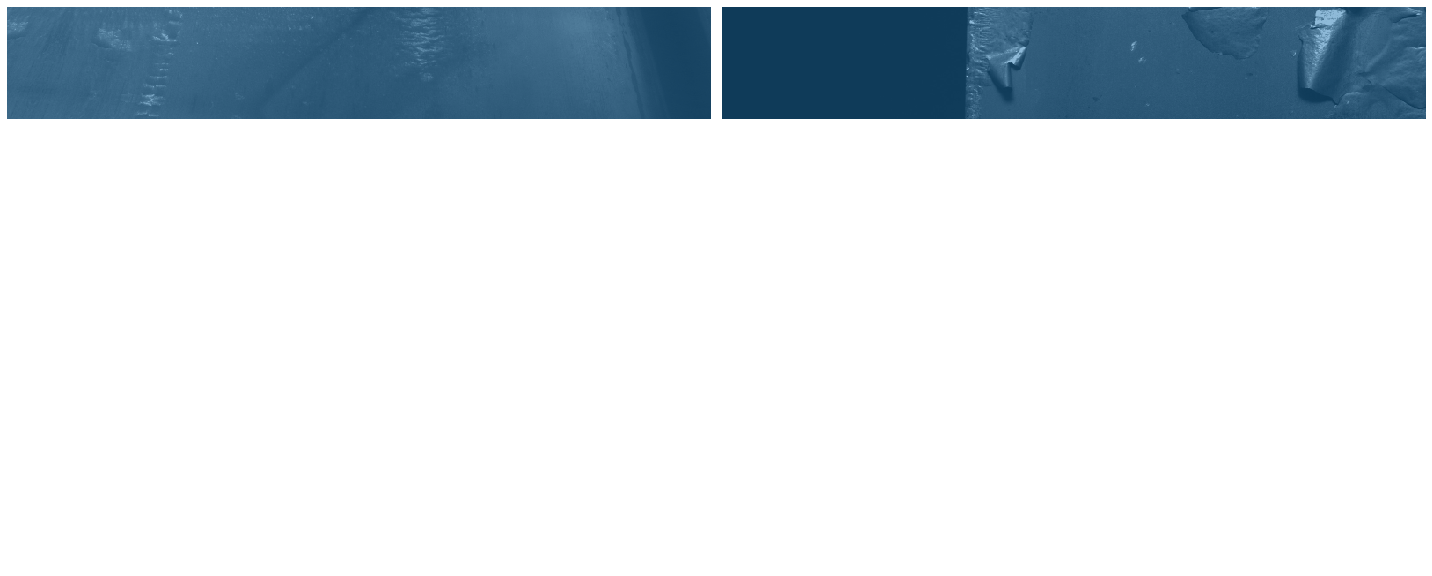

In [24]:
data.show_batch(4, figsize=(20,10))

### Create learner and training
Starting with low resolution training

##### Some metrics functions

In [131]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    argmax = (input.argmax(dim=1))
    comparison = argmax[mask]==target[mask]
    return torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()

def acc_camvid_with_zero_check(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    total = 0.
    batch_size = input.shape[0]
    for b in range(batch_size):
        mask = target[b] != void_code
        if(torch.sum(argmax[b]).item() == 0.0 and torch.sum(target[b]).item() == 0.0):
            total += 1
        else:
            comparison = argmax[b][mask]==target[b][mask]
            total += torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()
    return total / torch.tensor([batch_size]).float()


def calc_dice_coefficients(a, b, cats):
    def calc_dice_coefficient(seg, gt, cat: int):
        mask_seg = seg == cat
        mask_gt = gt == cat
        sum_seg = torch.sum(mask_seg.long()).float()
        sum_gt = torch.sum(mask_gt.long()).float()
        if sum_seg + sum_gt == 0:
            return torch.tensor(1.0).float(), torch.tensor(1.0).float()
        return torch.sum((seg[gt == cat] / cat).long()) * 2.0, (sum_seg + sum_gt)

    total_intersect: float = 0.0
    total_sum: float = 0.0
    if torch.sum(a) == torch.sum(b) == 0.:
        return 1.0
    for c in cats:
        intersect, sum = calc_dice_coefficient(a, b, c)
        total_intersect += intersect.float()
        total_sum += sum
    return total_intersect.float() / total_sum.float()


def dice_coefficient(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    total = 0.
    batch_size = input.shape[0]
    cats = [1, 2, 3, 4]
    for b in range(batch_size):
        total += calc_dice_coefficients(argmax[b], target[b], cats)
    return total / torch.tensor([batch_size]).float()


def accuracy_simple(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def dice_coefficient_old(input, target):
    target = target.squeeze(1)
    argmax = input.argmax(dim=1)
    common = (argmax==target).float().sum()
    return (2 * common) / (argmax.numel() + target.numel())

def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [147]:
test_input = torch.ones([8, 5, 360, 480]).long()
target_input = torch.ones([8, 1, 360, 480]).long() + 3
accuracy_simple(test_input, target_input), dice_coefficient(test_input, target_input), acc_camvid_with_zero_check(test_input, target_input)

(tensor(1.), tensor([0.2500]), tensor([1.]))

In [148]:
test_input = torch.ones([8, 1, 360, 480]).long()
target_input = torch.ones([8, 1, 360, 480]).long()
accuracy_simple(test_input, target_input), dice_coefficient(test_input, target_input), acc_camvid_with_zero_check(test_input, target_input)

(tensor(0.), tensor([0.]), tensor([0.]))

In [149]:
test_input = torch.zeros([8, 1, 360, 480]).long()
target_input = torch.zeros([8, 1, 360, 480]).long()
accuracy_simple(test_input, target_input), dice_coefficient(test_input, target_input), acc_camvid_with_zero_check(test_input, target_input)

(tensor(1.), tensor([1.]), tensor([1.]))

In [155]:
metrics=accuracy_simple,acc_camvid,acc_camvid_with_zero_check,dice_coefficient
wd=1e-2

In [137]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

In [138]:
learn.model_dir = Path('/kaggle/model')

In [139]:
lr_find(learn, num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


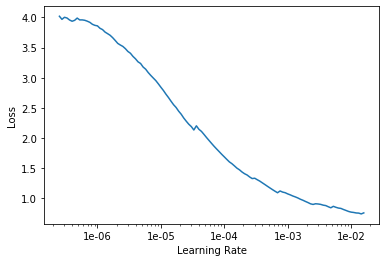

In [125]:
learn.recorder.plot()

In [140]:
lr=1e-4

In [141]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid,acc_camvid_with_zero_check,dice_coefficient,time
0,0.182197,0.125531,0.968728,0.022829,0.226924,0.219039,08:30
1,0.113875,0.096792,0.971985,0.117165,0.264970,0.217604,08:31
2,0.118297,0.088957,0.973167,0.171883,0.430278,0.356033,08:29
3,0.100758,0.080336,0.975564,0.258020,0.395494,0.282031,08:29
4,0.075693,0.091161,0.974003,0.258273,0.519040,0.397882,08:31
5,0.078605,0.094686,0.973569,0.210269,0.399497,0.309422,08:27
6,0.093132,0.103256,0.974641,0.280445,0.499308,0.368552,08:28
7,0.095311,0.114346,0.972869,0.116871,0.444002,0.394659,08:29
8,0.084321,0.068968,0.977580,0.347253,0.531720,0.378631,08:30
9,0.079176,0.067344,0.978782,0.350379,0.565125,0.401086,08:28


In [143]:
learn.save('stage-1')

In [144]:
learn.unfreeze()

In [145]:
lrs = slice(lr/100,lr)

In [146]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid,acc_camvid_with_zero_check,dice_coefficient,time
0,0.086434,0.064878,0.978966,0.349683,0.589412,0.429501,09:30
1,0.067167,0.065850,0.979007,0.349814,0.559515,0.407363,09:29
2,0.066841,0.072691,0.978970,0.338737,0.562062,0.415242,09:27
3,0.077595,0.067483,0.977981,0.272084,0.545722,0.426537,09:29
4,0.082497,0.072575,0.976529,0.417704,0.513528,0.319079,09:31
5,0.058402,0.068496,0.977854,0.305966,0.562172,0.427356,09:29
6,0.082382,0.069433,0.978170,0.265773,0.572555,0.456558,09:29
7,0.085117,0.107721,0.974714,0.409532,0.503369,0.307988,09:30
8,0.095834,0.217290,0.978526,0.411512,0.528479,0.341283,09:28
9,0.069925,0.064891,0.979434,0.385769,0.585564,0.402735,09:30


In [150]:
learn.save('stage-2');

### Go half size

In [156]:
size = src_size//2

In [157]:
data = (src.transform(get_transforms(flip_vert = True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [158]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.model_dir = Path('/kaggle/model')
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


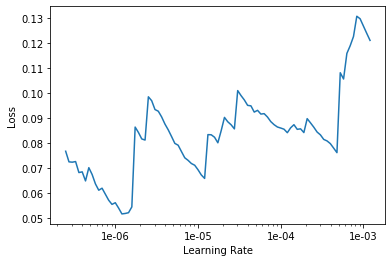

In [159]:
lr_find(learn, num_it=200)
learn.recorder.plot()

In [160]:
lr=1e-05

In [161]:
learn.fit_one_cycle(10, lrs, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid,acc_camvid_with_zero_check,dice_coefficient,time
0,0.090370,0.090329,0.978859,0.416997,0.519153,0.319989,08:30
1,0.080289,0.124938,0.979614,0.387845,0.587729,0.402854,08:30
2,0.079237,0.082900,0.976400,0.234781,0.578177,0.475088,08:29
3,0.081279,0.086189,0.978572,0.330077,0.588200,0.439222,08:28
4,0.087404,0.080372,0.976942,0.273673,0.554029,0.426654,08:29
5,0.108671,0.105055,0.976542,0.214792,0.389452,0.299172,08:30
6,0.085537,1.261291,0.978847,0.428705,0.583398,0.379907,08:31
7,0.108780,0.084026,0.978443,0.435987,0.477874,0.281818,08:29
8,0.066890,0.102195,0.979701,0.345892,0.534552,0.377285,08:29
9,0.063193,0.100406,0.979909,0.385934,0.552601,0.371017,08:30


In [162]:
learn.save('stage-3');

In [163]:
learn.unfreeze()

In [164]:
lrs = slice(lr/100,lr)

In [165]:
learn.fit_one_cycle(10, lrs, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid,acc_camvid_with_zero_check,dice_coefficient,time
0,0.068938,0.095280,0.980310,0.397540,0.558196,0.374110,09:30
1,0.103492,0.116122,0.980046,0.384378,0.544495,0.369246,09:29
2,0.071567,0.074920,0.980103,0.387708,0.483000,0.301031,09:31
3,0.069838,0.077194,0.979900,0.354201,0.525238,0.361453,09:31
4,0.069169,0.116959,0.979692,0.365845,0.550535,0.383720,09:28
5,0.070178,0.073672,0.979890,0.379844,0.448501,0.276914,09:27
6,0.073721,0.813652,0.979004,0.340393,0.556702,0.398471,09:29
7,0.056115,0.616776,0.979777,0.345248,0.504882,0.346596,09:31
8,0.069051,0.096161,0.979771,0.380541,0.449152,0.271484,09:30
9,0.064053,0.101669,0.979815,0.391780,0.444472,0.260169,09:29


In [168]:
learn.save('stage-4');

### Hook to save the best model during training

In [171]:
class SaveBestModel():
    def __init__(self, model, lr, name='best_model'):
        super().__init__(model.get_layer_opt(lr, None))
        self.name = name
        self.model = model
        self.best_loss = None
        self.best_acc = None
        
    def save_best_model(self):
        print(f'Saving best model as {self.name}')
        self.model.save(f'{self.name}')

    def on_epoch_end(self, metrics):
        super().on_epoch_end(metrics)
        loss, accuracies = metrics
        acc = accuracies[0]
        if self.best_acc == None or acc > self.best_acc:
            self.best_acc = acc
            self.best_loss = loss
            self.save_best_model()
        elif acc == self.best_acc and loss < self.best_loss:
            self.best_loss = loss
            self.save_best_model()

### Go Large

In [172]:
data = (src.transform(get_transforms(flip_vert = True), size=src_size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [173]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.model_dir = Path('/kaggle/model')
learn.load('stage-4');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


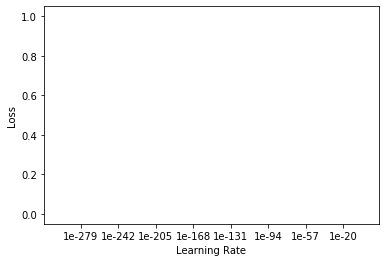

In [174]:
lr_find(learn, num_it=200)
learn.recorder.plot()

In [42]:
lr = 1e-5

In [177]:
# save_best_model = SaveBestModel(learn, lr, name='best_sgdr')
learn.fit_one_cycle(10, slice(lr), pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid,acc_camvid_with_zero_check,dice_coefficient,time
0,0.198553,0.194054,0.970081,0.083836,0.055372,0.023302,26:51
1,0.075051,0.075702,0.977950,0.351940,0.357530,0.208001,26:51
2,0.092887,0.070738,0.978324,0.362779,0.381627,0.222539,26:52
3,0.079229,0.071444,0.978584,0.355549,0.383767,0.229182,26:51
4,0.089540,0.075755,0.979112,0.381875,0.406159,0.239143,26:51
5,0.080206,0.068748,0.979341,0.367413,0.472645,0.312349,26:50
6,0.057182,0.070203,0.978926,0.376354,0.459156,0.291285,26:51
7,0.076835,0.068295,0.979453,0.373783,0.433577,0.269178,26:51
8,0.055451,0.067824,0.979206,0.396277,0.452885,0.277970,26:52
9,0.093869,0.069732,0.979211,0.371688,0.425301,0.261101,26:51


In [178]:
learn.save('stage-5');

In [179]:
learn.unfreeze()

In [180]:
lrs = slice(lr/100,lr)

In [181]:
learn.fit_one_cycle(10, lrs, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid,acc_camvid_with_zero_check,dice_coefficient,time
0,0.065866,0.067799,0.979291,0.368149,0.416242,0.254484,28:18
1,0.063210,0.071755,0.979328,0.359779,0.474285,0.317255,28:18
2,0.079829,0.066560,0.979001,0.370141,0.406293,0.244620,28:18
3,0.079990,0.069527,0.978968,0.330894,0.472452,0.328534,28:18
4,0.070014,0.064853,0.978870,0.402134,0.470353,0.290502,28:20
5,0.129547,0.065931,0.979382,0.390359,0.456904,0.284631,28:19
6,0.070681,0.064903,0.979108,0.400857,0.491670,0.313882,28:19
7,0.085538,0.064841,0.979676,0.359958,0.461549,0.301742,28:19
8,0.048573,0.063136,0.979870,0.381065,0.468028,0.299032,28:20
9,0.055831,0.063802,0.979808,0.376234,0.473880,0.306091,28:19


In [183]:
learn.save('stage-6');

In [184]:
learn.load('stage-6');

In [185]:
learn.export(file='/kaggle/model/export.pkl')

In [188]:
!pwd
!cp /kaggle/model/export.pkl /opt/fastai/fastai-exercises/nbs_gil
from IPython.display import FileLink
FileLink(r'export.pkl')

/opt/fastai/fastai-exercises/nbs_gil


/opt/fastai/fastai-exercises/nbs_gil/export.pkl

### Inference

In [ ]:
learn=None
gc.collect()

In [ ]:
test_images = (path/'test_images').ls()

In [ ]:
inference_learn = load_learner('/kaggle/model/')

In [ ]:
def predict(img_path):
    pred_class, pred_idx, outputs = inference_learn.predict(open_image(str(img_path)))
    return pred_class, pred_idx, outputs

def encode_classes(pred_class_data):
    pixels = np.concatenate([[0], torch.transpose(pred_class_data.squeeze(), 0, 1).flatten(), [0]])
    classes_dict = {1: [], 2: [], 3: [], 4: []}
    count = 0
    previous = pixels[0]
    for i, val in enumerate(pixels):
        if val != previous:
            if previous in classes_dict:
                classes_dict[previous].append((i - count, count))
            count = 0
        previous = val
        count += 1
    return classes_dict


def convert_classes_to_text(classes_dict, clazz):
    return ' '.join([f'{v[0]} {v[1]}' for v in classes_dict[clazz]])

In [ ]:
image_to_predict = train_images[16].name
display_image_with_mask(image_to_predict)
pred_class, pred_idx, outputs = predict(path/f'train_images/{image_to_predict}')
pred_class

#### Checking encoding methods

In [ ]:
encoded_all = encode_classes(pred_class.data)
print(convert_classes_to_text(encoded_all, 3))

In [ ]:
image_name = train_images[16]
print(get_y_fn(image_name))
img = open_mask(get_y_fn(image_name))
img_data = img.data
print(convert_classes_to_text(encode_classes(img_data), 3))
img_data.shape

### Loop through the test images and create submission csv

In [ ]:
import time
start_time = time.time()

defect_classes = [1, 2, 3, 4]
with open('submission.csv', 'w') as submission_file:
    submission_file.write('ImageId_ClassId,EncodedPixels\n')
    for i, test_image in enumerate(test_images):
        pred_class, pred_idx, outputs = predict(test_image)
        encoded_all = encode_classes(pred_class.data)
        for defect_class in defect_classes:
            submission_file.write(f'{test_image.name}_{defect_class},{convert_classes_to_text(encoded_all, defect_class)}\n')
        if i % 5 == 0:
            print(f'Processed {i} images\r', end='')
            
print(f"--- {time.time() - start_time} seconds ---")